In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table

import os
from os import getpid

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm, colors

import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.patches import Circle, Rectangle

from matplotlib.lines import Line2D

import xspec as x

import matplotlib
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec

from scipy import stats
from scipy.optimize import curve_fit

from tqdm.autonotebook import tqdm

import multiprocessing
import datetime

import scipy.odr as odr

from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel, Tophat2DKernel
from IPython.display import clear_output

/home/aleksei/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/aleksei/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/tmp/ipykernel_3974/2343654355.py:29: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
clusters_all = pd.read_csv("../data/eROSITA_30.0x30.0/Catalouges/cluster.dat", sep='\s+', header=0)
clusters = clusters_all[clusters_all["M500"]>1e14]
clusters = clusters[clusters["flag"]==0]

wd = "../data/eROSITA_30.0x30.0/Phox/"
mylist = sorted(os.listdir(wd))

phlists = [item for item in mylist if item[:6] == "phlist"]

print(phlists)

phlists_redshifts = [fits.open(wd+item)[0].header["REDSHIFT"] for item in phlists]#[::-1]

print(phlists_redshifts)

clusters

['phlist_124.fits', 'phlist_128.fits', 'phlist_132.fits', 'phlist_136.fits', 'phlist_140.fits']
[0.174192889973847, 0.13708140389145, 0.101142861718869, 0.0663401914452304, 0.032637492755919]


,ihal,x_pix,y_pix,z_pix,Rrel,Mvir,z_true,z_obs,M500,R500,Mstar500,Mgas500,T500,Lx500,Ysz500,M200,R200,flag
171,110,0.970969,0.479718,0.014316,0.004703,2.432930e+14,0.157249,0.157891,1.366960e+14,688.128,4.470500e+12,1.209540e+13,2.44633,0.707698,0.000003,2.049620e+14,1068.920,0
187,163,0.388924,0.570999,0.016006,0.004675,2.390080e+14,0.157312,0.159659,1.126680e+14,645.187,2.896080e+12,1.061830e+13,2.43074,0.532571,0.000003,2.049290e+14,1068.880,0
350,77,0.380183,0.570491,0.033800,0.005197,3.282700e+14,0.157977,0.157810,1.925340e+14,771.351,5.156740e+12,2.121000e+13,3.21771,1.515690,0.000005,2.887220e+14,1198.270,0
820,68,0.735543,0.863489,0.086085,0.005228,3.341870e+14,0.159935,0.160192,1.800240e+14,754.271,6.340420e+12,1.596800e+13,3.57076,0.972861,0.000004,2.724390e+14,1175.290,0
1245,111,0.804864,0.355207,0.133510,0.004668,2.379170e+14,0.161713,0.161111,1.321030e+14,680.349,4.667490e+12,9.869480e+12,2.78095,0.452088,0.000003,1.944720e+14,1050.360,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18589,113,0.839159,0.495644,0.394607,0.011199,2.242680e+14,0.063945,0.063977,1.184480e+14,615.838,2.883010e+12,1.160680e+13,2.22808,0.537683,0.000002,1.889120e+14,976.536,0
18610,199,0.149218,0.307198,0.406194,0.011455,2.400200e+14,0.064342,0.064928,1.282700e+14,632.408,3.427130e+12,1.130680e+13,2.26553,0.455429,0.000002,1.935300e+14,984.440,0
19523,349,0.373303,0.943536,0.987909,0.010375,1.783400e+14,0.084342,0.084015,1.055570e+14,592.650,3.313370e+12,6.942770e+12,2.39539,0.231120,0.000002,1.464050e+14,897.005,0
19771,323,0.759637,0.387809,0.508332,0.020783,1.912580e+14,0.034099,0.033707,1.272360e+14,616.706,3.593030e+12,1.067760e+13,2.61661,0.651073,0.000003,1.638830e+14,910.698,0


In [3]:
geometry = pd.read_csv("../data/eROSITA_30.0x30.0/Catalouges/geometry.dat", sep='\s+', header=2)


binned_clusters = {}
   
for borders in list(zip(geometry["z_start"], geometry["z_end"], geometry["zslice"], geometry["snapNr"])):
    
    for ind in clusters.index:

        zt = clusters.loc[ind]["z_true"]

        if zt > borders[0] and zt < borders[1]:

            binned_clusters[ind] = borders[2], str(borders[3])
                
#sorted(binned_clusters.items())

redshifts = [clusters.loc[i]["z_true"] for i in clusters.index]

geometry

,snapNr,ztab,zslice,z_start,z_end,x0,y0,z0,depth,width
0,144,0.001001,0.008625,0.000000,0.017281,230.604600,52.929941,38.137176,73.327162,21.167728
1,140,0.033671,0.033822,0.017281,0.050478,305.341400,149.855590,172.109480,139.387980,82.573299
2,136,0.067408,0.067555,0.050478,0.084760,97.871486,134.586170,117.805860,141.855220,163.761220
3,132,0.102245,0.102388,0.084760,0.120158,185.353850,229.067940,294.134880,144.222380,246.344710
4,128,0.138220,0.138357,0.120158,0.156713,146.337120,179.784950,264.241690,146.478010,330.262680
5,124,0.175368,0.175501,0.156713,0.194460,170.716390,187.570430,175.891600,148.610980,415.447530


### Stacking

[(18.1051972, 6.1070323), (17.7271312, 6.630200500000001), (17.823133000000002, 7.188382600000001), (17.3127979, 7.0736115999999996), (18.334033899999998, 6.3307903), (17.830635700000002, 5.8878328), (18.1792291, 6.2261845000000005), (17.9049526, 6.3502183), (18.085793499999998, 6.8997127), (18.1576387, 6.718063300000001), (17.878417, 6.7980556), (18.2064844, 6.608420500000001), (18.2252542, 6.8341435), (17.6653126, 6.943491999999999), (17.4733771, 7.1798983), (17.4977113, 6.3645586000000005), (17.621748399999998, 6.150218199999999), (17.3292085, 6.307717299999998), (18.2317189, 6.417286300000001), (17.689520199999997, 6.7529965), (17.723760400000003, 6.8903833), (17.1893215, 6.8659009), (17.7305311, 6.739455099999999), (17.205538599999997, 6.7287625), (17.290819600000003, 6.956674), (17.5511899, 6.086362900000001), (18.332438800000002, 6.408496599999999), (17.9986147, 6.335175100000001), (17.3688259, 6.580178799999999), (17.3264935, 7.1550688000000005), (17.7891025, 6.634273)]


<Figure size 640x480 with 0 Axes>

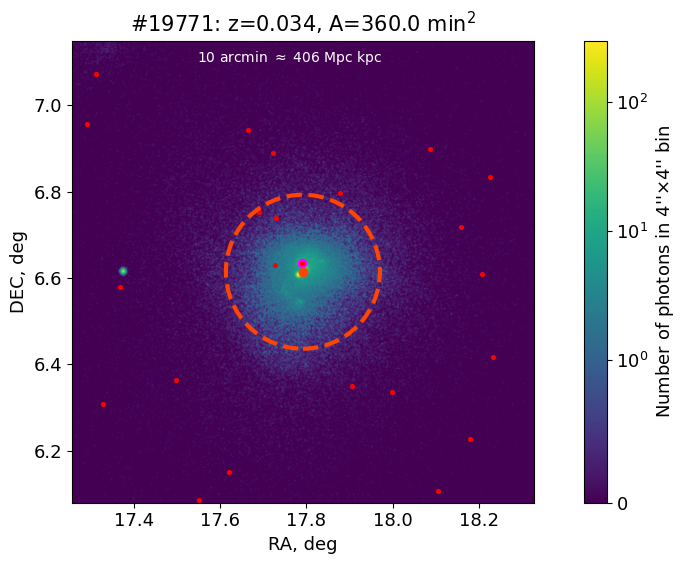

In [24]:
%run -i 'scripts.py'

plt.figure(figsize=(16,6))

cl_num = 19771
RRR = 1.0

#plt.subplot(121)
pho_hist = extract_photons_from_cluster(cl_num, 
                                        r = RRR, 
                                        centroid=True, 
                                        delete_bright_regions=False, 
                                        draw=True,
                                        draw_additional=False)

#plt.subplot(122)
#pho_hist = extract_photons_from_cluster(cl_num, 
#                                        r = RRR, 
#                                        centroid=True, 
#                                        delete_bright_regions=True, 
#                                        draw=True,
#                                        draw_additional=False)

plt.show()

In [ ]:
%run -i 'scripts.py'

plt.figure(figsize=((size)*7+6*3, 5*12+11*2.5))

draw_84_panels(False)

plt.savefig('panels_unfiltered.png', format='png', dpi=200, bbox_inches='tight')

plt.show()

In [171]:
%run -i 'scripts.py'

length = 1503 * 2

total_hist = np.zeros((length, length))

for cl_num in tqdm(clusters.index[:84]):
     
    pho_hist = extract_photons_from_cluster(cl_num, r = 1.0, draw=False, delete_bright_regions=False)
    
    total_hist = np.add(total_hist, pho_hist)

  0%|          | 0/84 [00:00<?, ?it/s]

1502.5


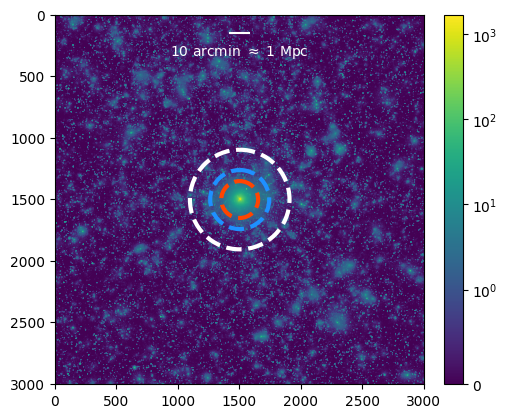

In [210]:
half_length = int(length/2)
r500r = int(half_length/10)  # 1000/343000*180/np.pi*3600/4

plt.imshow(np.rot90(total_hist), norm=matplotlib.colors.SymLogNorm(linthresh=1, linscale=1), origin='upper')
plt.colorbar(fraction=0.046, pad=0.04)

plt.gca().add_patch(plt.Circle((half_length, half_length), r500r, 
                               color='orangered', linestyle="--", lw=3, fill = False))
plt.gca().add_patch(plt.Circle((half_length, half_length), r500r*1.6, 
                               color='dodgerblue', linestyle="--", lw=3, fill = False))
plt.gca().add_patch(plt.Circle((half_length, half_length), r500r*2.7, 
                               color='white', linestyle="--", lw=3, fill = False))

x_s = (plt.gca().get_xlim()[1]+plt.gca().get_xlim()[0])/2
print(x_s)
y_s = (plt.gca().get_ylim()[1]-plt.gca().get_ylim()[0])*0.95+plt.gca().get_ylim()[0]
y_S = (plt.gca().get_ylim()[1]-plt.gca().get_ylim()[0])*0.90+plt.gca().get_ylim()[0]   
plt.plot((x_s+r500r/2, x_s-r500r/2), (y_s, y_s), color='white')
plt.text(x_s, y_S, f'10 arcmin $\\approx$ 1 Mpc', 
         color='white', ha='center', va='center')

plt.show()

#### Here we obtain brightness profile:

In [208]:
%run -i 'scripts.py'

brightness = []

r_pixels_max = 10*r500r

#ring_width = 10

setka = np.geomspace(1, r_pixels_max, 30).astype(int)

c2 = [r_pixels_max, r_pixels_max]

setka

array([   1,    1,    1,    2,    2,    3,    4,    5,    7,    9,   12,
         16,   20,   26,   34,   43,   56,   72,   93,  120,  155,  199,
        256,  330,  425,  547,  703,  905, 1165, 1500])

In [209]:
for i in tqdm(range(0, len(setka)-1)):

    k1 = kruzhok(setka[i], c2, total_hist, r_pixels_max)
    k2 = kruzhok(setka[i+1], c2, total_hist, r_pixels_max)
    ring = k2[0]-k1[0]
    brightness.append(ring.sum()/(sum(k2[1].flatten())-sum(k1[1].flatten())))


  0%|          | 0/29 [00:00<?, ?it/s]

/tmp/ipykernel_4671/2352720642.py:6: RuntimeWarning: invalid value encountered in scalar divide
  brightness.append(ring.sum()/(sum(k2[1].flatten())-sum(k1[1].flatten())))


In [214]:
r500r

150

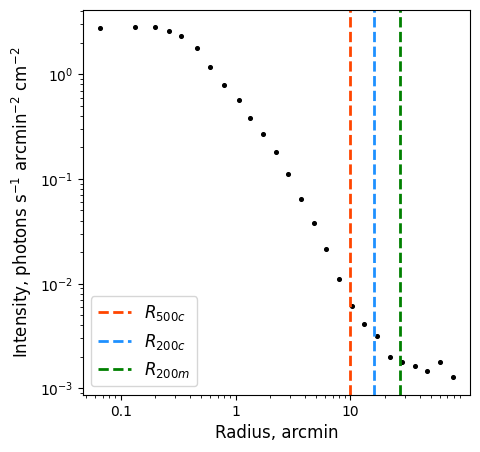

In [229]:
plt.figure(figsize=(5,5))

#r500_pix = int(1000/343000*180/np.pi*3600/4)

# np.linspace(0, r_pixels_max+1, r_pixels_max+1)/r500_pix

#plt.plot(setka[:-1]/r500r*(10*998/1000), np.array(brightness)/10000/(4/60)**2)

#plt.axvline((brightness.index(max(brightness))+1)/r500_pix, ls='--', color='black')

plt.xlabel("Radius, arcmin", fontsize=12)  # "Radius in units of $R_{500}$")
plt.ylabel("Intensity, photons s$^{-1}$ arcmin$^{-2}$ cm$^{-2}$", fontsize=12) # "Brightness in relative units")

#plt.axhline(brightness_max, ls='--', color='red', 
#label=f'{threshold*100:.2f} % cutoff\nat brightness = {brightness_max:.2f}')
plt.xscale("log")
plt.yscale("log")

plt.axvline(10*998/1000, linestyle='--', color='orangered', label='$R_{500c}$', lw=2)
plt.axvline(10*998/1000*1.6, linestyle='--', color='dodgerblue', label='$R_{200c}$', lw=2)
plt.axvline(10*998/1000*2.7, linestyle='--', color='green', label='$R_{200m}$', lw=2)

plt.scatter(setka[:-1]/r500r*(10*998/1000), np.array(brightness)/10000/(4/60)**2/1000*140, color='black', s=7)

plt.legend(loc=3, fontsize=12)
#plt.subplots_adjust()                 
#plt.tight_layout()
plt.xticks([0.1, 1, 10], [0.1, 1, 10])

plt.show()

In [10]:
            # another method of excluding bright pixels (by making rings):
            
            if False:
                
                ffltr =  nmhg1_reserve*0 #(nmhg1_reserve == 0)
                
                #plt.imshow(ffltr)
                #plt.show()
                
                r_pixels_max = int(R*3600/ang_res)
                brightness = []   #[k0[0].sum()/sum(k0[1].flatten())]
            
                ring_width = 20
                                  
                for rr in range(0, r_pixels_max+1, ring_width):
        
                    k1 = kruzhok(rr, c1, nmhg_radial, r_pixels_max+1)
                    k2 = kruzhok(rr + ring_width, c1, nmhg_radial, r_pixels_max+1)
                    ring = k2[0]-k1[0]
                    koltso = (sum(k2[1].flatten())-sum(k1[1].flatten()))
                    print('3.14 * (', (rr + ring_width)**2, '-', rr**2, ') =', koltso)
                     
                    plt.figure(figsize=(19,3))                
                    plt.subplot(151)
                    ring = np.rot90(ring)
                    plt.imshow(ring, 
                               norm=matplotlib.colors.SymLogNorm(linthresh=1, linscale=1), 
                               origin='upper')
                    plt.colorbar(fraction=0.046, pad=0.04)
                    
                    plt.subplot(152)
                    bbiinnss = np.geomspace(1, np.max(ring.flatten()), 50)
                    bbiinnss = sorted(bbiinnss)
                    #print(ring.flatten(), bbiinnss)
                    amount_in_bin, bin_borders = np.histogram(ring.flatten(), bins = bbiinnss)
                    #print(amount_in_bin, bin_borders)                    
                    amount_in_bin = amount_in_bin/koltso
                    bin_centers = (bin_borders[:-1]+bin_borders[1:])/2
                    #bin_centers = [int(b) for b in bin_borders[:-1]]
                    plt.plot(bin_centers, amount_in_bin)
                    
                    plt.subplot(153)
                    
                    cumulative = [sum(amount_in_bin[:i]) for i in range(0, len(amount_in_bin))]
                    number_cutoff = bin_centers[np.argmin(np.abs(cumulative-cumulative[-1]*threshold))]
                    index_cutoff = list(bin_centers).index(number_cutoff)
                    threshold_new = sum(amount_in_bin[:index_cutoff]) / cumulative[-1]
                    
                    plt.plot(bin_centers, cumulative)
                    plt.axhline(cumulative[-1], ls='-.', color='green', label="Total sum")
                    plt.axhline(cumulative[-1]*threshold, ls='-.', color='red', label=f'Total sum $\\times$ {threshold}')
                    plt.axvline(number_cutoff, ls='--', color='red', 
                                label=f'Cutoff at\nnumber = {number_cutoff:.2f};\n{threshold_new*100:.2f}% reached')
                    plt.legend(loc=4)
                    
                    plt.subplot(152)
                    plt.axvline(number_cutoff, ls='--', color='red')
                    
                    plt.subplot(154)
                    filter_mask2 = ring <= number_cutoff
                    ring = ring*filter_mask2
                    filter_mask3 = filter_mask2 == 0
                    plt.imshow(filter_mask3)
                    
                    plt.subplot(155)
                    ffltr = ffltr + ring

                    plt.imshow(ffltr, 
                               norm=matplotlib.colors.SymLogNorm(linthresh=1, linscale=1), 
                               origin='upper')
                    plt.colorbar(fraction=0.046, pad=0.04)
                    #plt.subplots_adjust()
                    plt.tight_layout()
                    plt.show()
            
                nmhg1 = np.rot90(ffltr, 3)


2